# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then populate the node with the data of first client:

`./scripts/fedbiomed_run node dataset add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node dataset list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [ ]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [2]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List

#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
        
    # Dependencies for training plan
    def init_dependencies(self):
        deps = ["import numpy as np",
            "import monai",
            "from torch.nn import MSELoss",
            "from monai.utils import set_determinism, first",
            "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
            "from monai.data import DataLoader, Dataset, CacheDataset",
            "from monai.networks.nets import GlobalNet",
            "from monai.config import USE_COMPILED",
            "from monai.networks.blocks import Warp",
            "from monai.apps import MedNISTDataset",
            "from opacus.validators import ModuleValidator"]
        return deps 
    
    # Model for training
    def init_model(self):
        
        # Define model related attributes 
        self.image_loss = MSELoss()
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
        
        # Define model 
        model = GlobalNet(image_size=(64, 64),
                          spatial_dims=2,
                          in_channels=2,  # moving and fixed
                          num_channel_initial=16,
                          depth=3)
        
        return model 
    
    # Optimizer for training
    def init_optimizer(self, optimizer_args):
        optimizer = torch.optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])
        
        return optimizer


    def training_data(self):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict, transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl,  shuffle=True, num_workers=0)
    
    def training_step(self, moving, fixed):
        ddf = self.model().forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [3]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [4]:
model_args = {}

training_args = {
    'loader_args': { 'batch_size': 16, }, 
    'optimizer_args': {
        'lr': 1e-5
    },
    'use_gpu': True,
    'epochs': 4, 
    'dry_run': False
}

tags =  ['#MEDNIST', '#dataset']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [ ]:
exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [ ]:
exp.run()

Save trained model to file

In [7]:
exp.training_plan().export_model('./trained_model')

## Training with DP

### Download and execute RDP Accountant Module
Following actions will download RDP module to calculate privacy budget and create a function called `get_iterations` which going to be used for calculating the number training iterations that respects the privacy budget. The result of the function will be used for finding max number of rounds for the experiment.

In [8]:
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/tensorflow/privacy/7eea74a6a1cf15e2d2bd890722400edd0e470db8/research/hyperparameters_2022/rdp_accountant.py')
rdp_accountant = response.read()
exec(rdp_accountant)

def get_iterations(target_delta, sigma, q, max_epsilon, max_N):
    """Computes max number of iterations given budget parameters

    Args:
        target_delta: If not `None`, the delta for which we compute the corresponding epsilon.
        sigma: sigma to be used in Gaussian DP mechanism
        q: training sample ratio
        max_epsilon: Maximum budget allowed
         max_N: Maximum number of iterations

    Returns:
        An integer number of iterations, and the evolution of the budget
    Raises:
        ValueError: If target_eps and target_delta are messed up.
    """

    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(q=q,
                      noise_multiplier=sigma,
                      steps=1,
                      orders=orders)
    epsilon_range = [get_privacy_spent(orders, i * rdp, target_delta=target_delta) for i in range(max_N)]
    max_training_steps = int(np.sum(np.array([x[0] for x in epsilon_range]) < max_epsilon))
    return max_training_steps, [x[0] for x in epsilon_range][:max_training_steps]

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strength of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [ ]:
from fedbiomed.researcher.requests import Requests
req = Requests()
query_nodes = req.list()

In [ ]:
query_nodes

In [11]:
min_dataset_size = min([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['tags'] == ['#MEDNIST', '#dataset']]) #see training data in model
tot_dataset_size = sum([dataset['shape'][0] for i in query_nodes for dataset in query_nodes[i] if dataset['tags'] == ['#MEDNIST', '#dataset']]) #see training data in model

In [13]:
q = training_args['loader_args']['batch_size']/min_dataset_size
sigma = 0.4
clip = 0.005
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e2)

In [14]:
N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [15]:
max_rounds = N/(training_args['epochs'])

In [16]:
assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of FL rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of FL rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of FL rounds for (10.0,1.6962377446822949e-06)-LDP training is 25.0
The selected number of FL rounds, 5,implies (5.175489863122008,1.6962377446822949e-06,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

## Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [ ]:
model_args = {}
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
training_args.update(LDP)
training_args

## Declare and run the LDP training

In [ ]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

In [ ]:
exp_LDP.run()

## CDP

### Dimensioning the training parameters with CDP

In [19]:
import numpy as np
num_clients = len([query_nodes[i][0]['shape'][0] for i in query_nodes])

# Here we use the same parameters as LDP to evaluate the number of rounds, 
# since we are performing record-level DP

q = training_args['loader_args']['batch_size']/min_dataset_size 
sigma = 0.4#/(np.sqrt(num_clients)*training_args['batch_size'])
clip = 0.005
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e2)

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [20]:
max_rounds = N/(training_args['epochs'])
print(max_rounds)

25.0


In [ ]:
assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

## Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters.

In [ ]:
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma/np.sqrt(num_clients), 'clip': clip}}
training_args.update(CDP)
training_args

## Declare and run the CDP training

In [ ]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

In [ ]:
exp_CDP.run()

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [25]:
!pip install matplotlib -q
!pip install gdown -q

In [ ]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

Download the testing dataset on the local temporary folder.

In [ ]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [28]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [ ]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [ ]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.training_plan().model()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.training_plan().model()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.training_plan().model()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

In [ ]:
exp_LDP.aggregated_params()[rounds - 1]['params']

In [36]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = tensor(0.8452, grad_fn=<AliasBackward0>)
---> Results for training with LDP
SSIM = tensor(0.3316, grad_fn=<AliasBackward0>))
---> Results for training with CDP
SSIM = tensor(0.3984, grad_fn=<AliasBackward0>))


Finally, we can print some example of predictions of all models from the testing dataset.

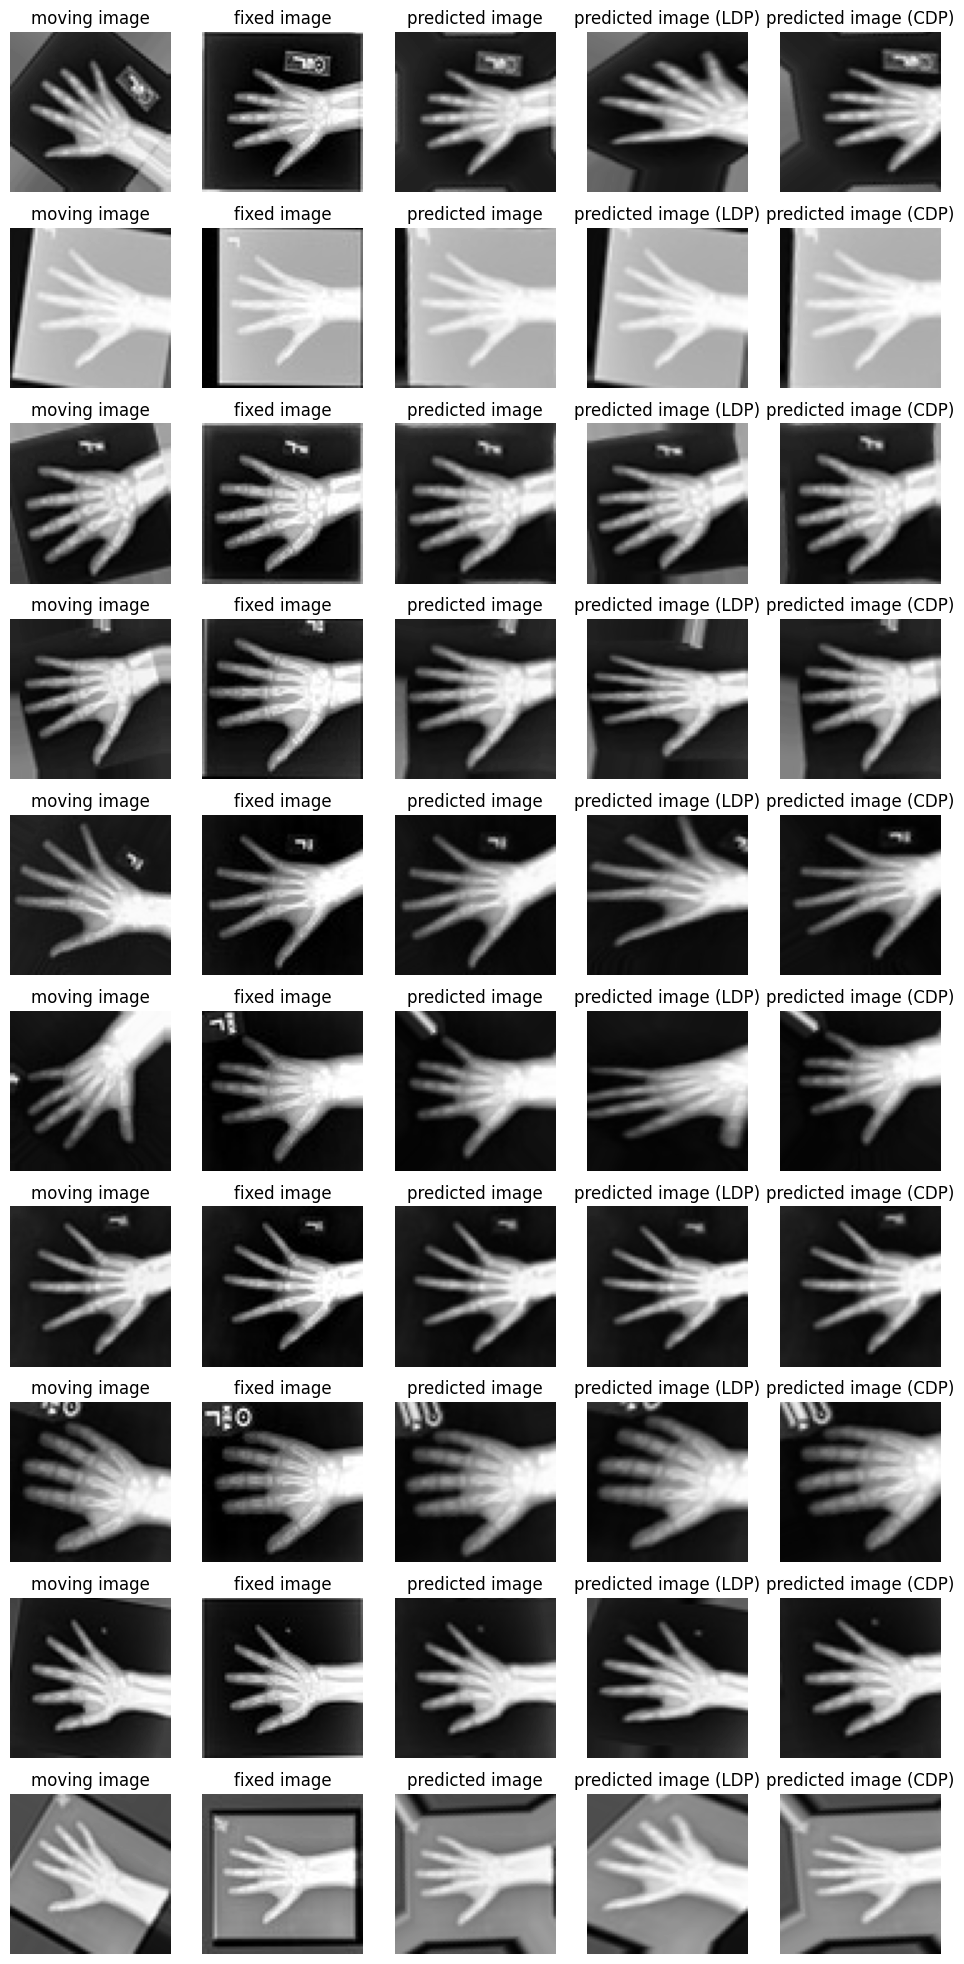

2024-04-03 13:02:07,551 fedbiomed DEBUG - Node: NODE_a16525b2-5b6a-42cf-9cef-ff746b2a6d4b polling for the tasks

2024-04-03 13:03:23,001 fedbiomed DEBUG - Node: NODE_90a7e795-9022-4bf0-b6c6-f1a2394b6dac polling for the tasks

In [37]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()